# Intro til Maskinlæring i Akvakultur (RAS)

Denne notebooken demonstrerer hvordan vi kan bruke data fra et RAS-anlegg til å forstå sammenhenger og lage enkle prediksjoner.

**Mål:**
1. Laste inn data (som fra Excel).
2. Se på dataene (Visualisering).
3. Lage en enkel modell for å forutsi biomasse (Maskinlæring).

In [139]:
# Vi importerer nødvendige verktøy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Setter en pen stil på plottene
sns.set_theme(style="whitegrid")

## Steg 1: Laste inn data
Vi later som vi henter data fra loggen til anlegget. Her ligger det i en CSV-fil (som er lett å eksportere fra Excel).

In [140]:
filename = "data/ras_data.csv"
# Laste inn data
df = pd.read_csv(filename)

# Vise de første 5 radene
df.head()

,Dato,Temperatur_C,Oksygen_mgL,Foring_kg,Biomasse_kg
0,2024-01-01,12.5,9.2,150,5000
1,2024-01-02,12.6,9.1,155,5050
2,2024-01-03,12.4,9.3,152,5100
3,2024-01-04,12.5,9.0,158,5160
4,2024-01-05,12.7,8.9,160,5220


In [141]:
df.columns

Index(['Dato', 'Temperatur_C', 'Oksygen_mgL', 'Foring_kg', 'Biomasse_kg'], dtype='object')

In [142]:
df.describe()

,Temperatur_C,Oksygen_mgL,Foring_kg,Biomasse_kg
count,30.000000,30.000000,30.000000,30.000000
mean,12.756667,8.873333,166.766667,5933.666667
std,0.315882,0.352267,9.242642,611.704703
min,12.300000,8.000000,150.000000,5000.000000
25%,12.500000,8.625000,160.000000,5425.000000
50%,12.700000,9.000000,165.000000,5915.000000
75%,12.975000,9.100000,175.000000,6410.000000
max,13.500000,9.400000,185.000000,6990.000000


In [143]:
target = 'Biomasse_kg'
features = df.columns.drop(['Dato', target])

## Steg 2: Utforske dataene (EDA)
Før vi gjør noe "smart", må vi se på hva vi har. Er det noen sammenhenger?

### Temperatur og oksygen over tid

In [144]:
def plot_time_series(df, date_col, value_col, label=None, title=None, figsize=(18, 6), marker='o', color=None):
    """
    Plott en tidsserie fra dataframe uten å endre originaldata.
    date_col: kolonnenavn med datoer (string)
    value_col: kolonnenavn med verdier som skal plottes (string)
    label: etikett i legend (string)
    title: plot-tittel (string)
    """
    x = pd.to_datetime(df[date_col])
    y = df[value_col]

    plt.figure(figsize=figsize)
    sns.lineplot(x=x, y=y, marker=marker, label=label or value_col, color=color)
    plt.xticks(rotation=45)
    plt.xlabel(date_col)
    plt.ylabel(label or value_col)
    plt.title(title or f"{label or value_col} over time")
    plt.show()

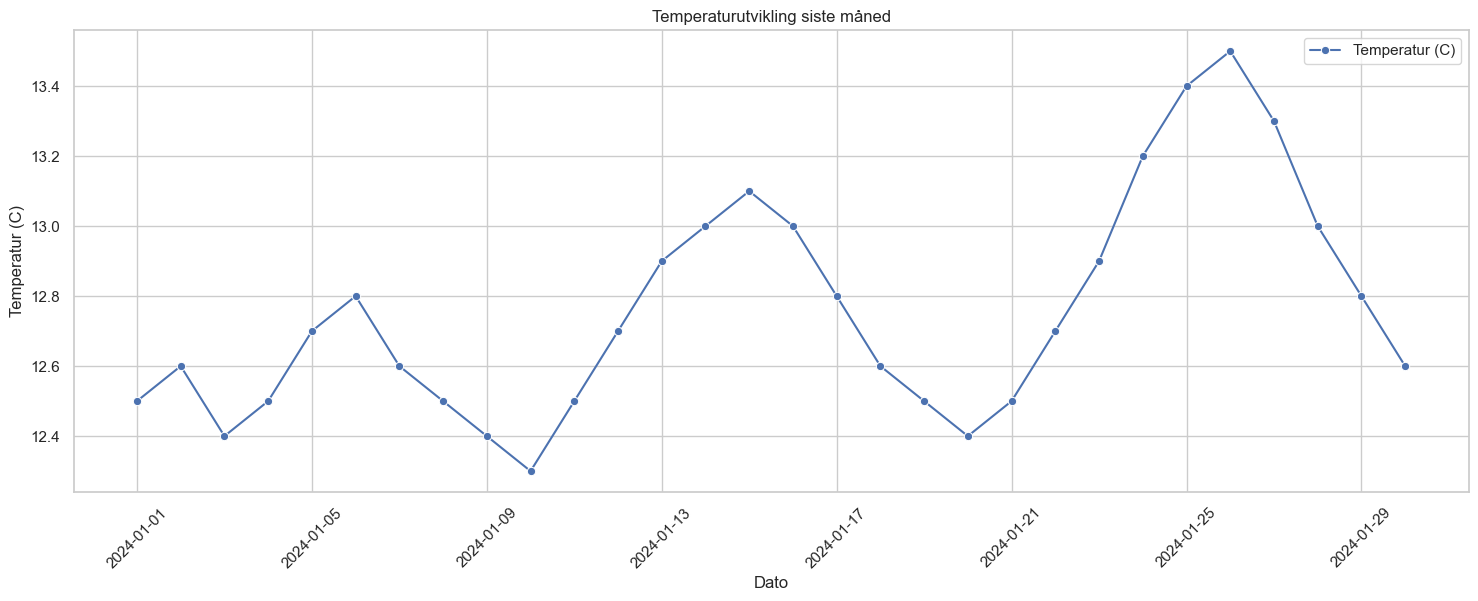

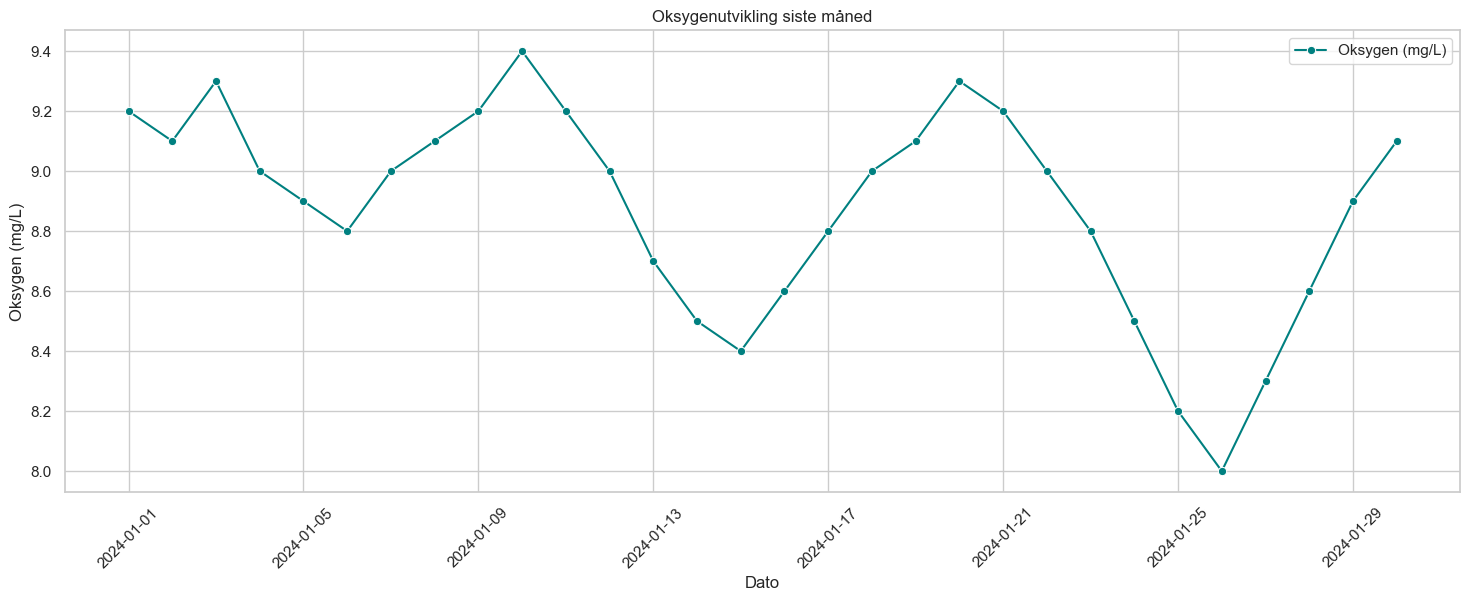

In [145]:
# Bruk funksjonen for temperatur
plot_time_series(df, 'Dato', 'Temperatur_C', label='Temperatur (C)', title="Temperaturutvikling siste måned")

# Bruk funksjonen for oksygen
plot_time_series(df, 'Dato', 'Oksygen_mgL', label='Oksygen (mg/L)', title="Oksygenutvikling siste måned", color='teal')

Av grafene kan vi se:
- Repeterende (sykliske) mønstre i både temperatur og oksygen
- en økende trend i temperatur
- en nedadgående trend i oksygen.

### Sammenheng biomasse og de ulike "features" / parametre

In [146]:
def scatterplot_feature_vs_target(df, feat_list, target, figsize_per_feature=6, color='salmon', s=100):
    """
    Plot scatter plots of target vs each feature in feat_list.
    Returns (fig, axes).
    """
    n = len(feat_list)
    if n == 0:
        raise ValueError("feat_list is empty")

    fig, axes = plt.subplots(1, n, figsize=(figsize_per_feature * n, 5), squeeze=False)
    for i, f in enumerate(feat_list):
        ax = axes[0, i]
        sns.scatterplot(data=df, x=f, y=target, s=s, ax=ax, color=color)
        try:
            corr = df[f].corr(df[target])
            corr_text = f"{corr:.2f}"
        except Exception:
            corr_text = "n/a"
        ax.set_title(f"{target} vs {f}\nKorrelasjon: {corr_text}")
        ax.set_xlabel(f)
        ax.set_ylabel(target)

    plt.tight_layout()
    plt.show()
    return fig, axes

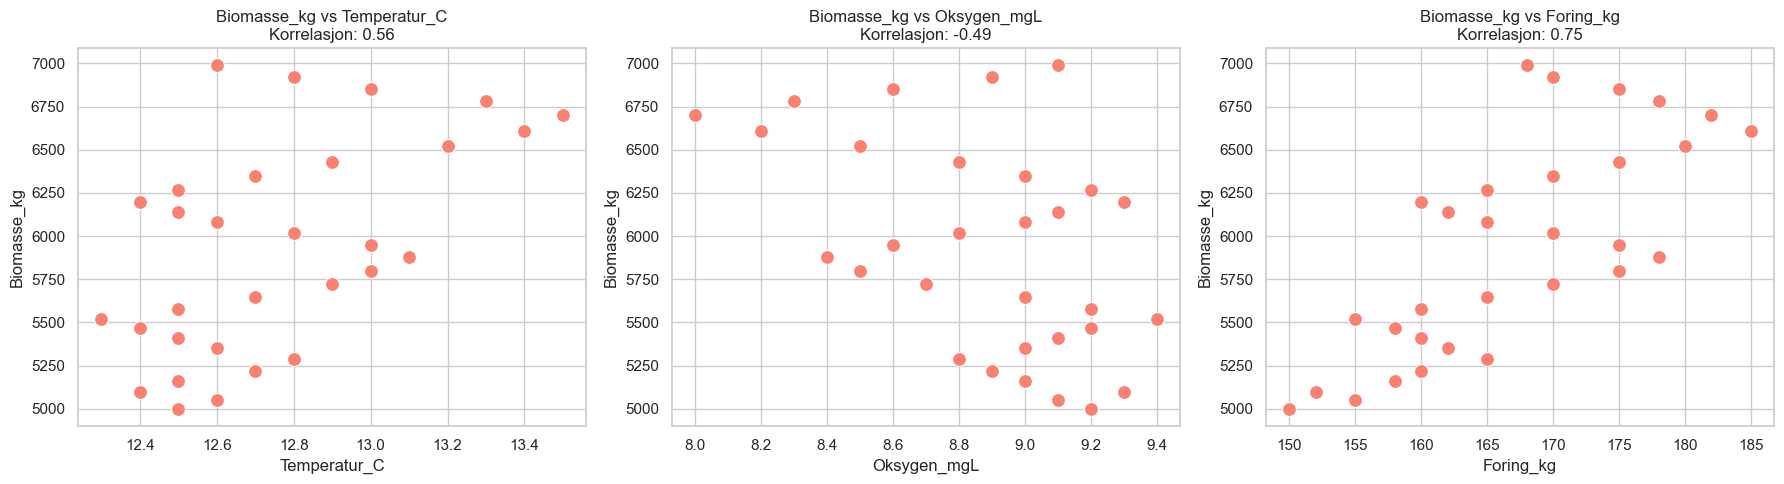

(<Figure size 1800x500 with 3 Axes>,
 array([[<Axes: title={'center': 'Biomasse_kg vs Temperatur_C\nKorrelasjon: 0.56'}, xlabel='Temperatur_C', ylabel='Biomasse_kg'>,
         <Axes: title={'center': 'Biomasse_kg vs Oksygen_mgL\nKorrelasjon: -0.49'}, xlabel='Oksygen_mgL', ylabel='Biomasse_kg'>,
         <Axes: title={'center': 'Biomasse_kg vs Foring_kg\nKorrelasjon: 0.75'}, xlabel='Foring_kg', ylabel='Biomasse_kg'>]],
       dtype=object))

In [147]:
# Scatterplots: Biomasse vs hver feature
target = 'Biomasse_kg'
feat_list = features if 'features' in globals() else [c for c in df.columns if c not in ['Dato', target, 'endring']]

scatterplot_feature_vs_target(df, feat_list, target)

## Steg 3: Maskinlæring (Enkel modell)
Kan vi lære datamaskinen å gjette biomasse basert på temperatur og fôring?

Vi bruker en **Lineær Regresjon**. Tenk på det som å tegne den "beste rette linjen" gjennom punktene.

In [148]:
def train_model(df, features, target, test_size=0.2, random_state=42):
    """
    Trener en LineærRegresjon på df[features] for å predikere df[target].
    Returnerer: X_test, y_test, modell
    """
    X = df[features]
    y = df[target]

    # Del data i trening og test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Tren modellen
    modell = LinearRegression()
    modell.fit(X_train, y_train)

    print("Modellen er ferdig trent!")
    return X_test, y_test, modell


In [149]:
# 1. Velg hva vi vil bruke til å gjette (Features) og hva vi vil gjette (Target)
features = ['Temperatur_C', 'Foring_kg']
target = 'Biomasse_kg'

X_test, y_test, modell = train_model(df, features, target)

Modellen er ferdig trent!


## Steg 4: Hvor bra traff vi?
La oss se hva modellen gjetter på test-dataene våre, og sammenligne med fasiten.

In [150]:
def plot_actual_vs_predicted(y_true, prediksjoner, y_true_label="Faktisk", pred_label="Predikert"):
    # Plotte faktisk vs prediksjon
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=prediksjoner, s=100)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2) # Fasit-linje
    plt.legend(['Modell vs faktisk', 'Perfekt (y=x)'], loc='best')
    plt.xlabel(y_true_label)
    plt.ylabel(pred_label)
    plt.title("Hvor godt treffer modellen? (På linjen = Perfekt)")
    plt.show()


def predict_and_show(modell, X_test, y_test, round_decimals=1):
    """
    Lager prediksjoner med `modell` på `X_test` og returnerer en DataFrame med:
      - Faktisk <y_test.name>
      - Modellens prediksjon (<y_test.name>)
      - Feil (<y_test.name>) = Faktisk - Predikert

    Deriverer navnet på kolonnen fra y_test.name. Returnerer resultat-DataFrame med samme indeks som y_test.
    """
    col_base = y_test.name or "target"
    y_pred = modell.predict(X_test)
    preds = pd.Series(y_pred, index=y_test.index).round(round_decimals)

    col_true = f"Faktisk ({col_base})"
    col_pred = f"Predikert ({col_base})"
    col_err = f"Feil ({col_base})"

    resultat = pd.DataFrame({col_true: y_test, col_pred: preds})
    resultat[col_err] = (resultat[col_true] - resultat[col_pred]).round(round_decimals)

    plot_actual_vs_predicted(y_test, preds, y_true_label=col_true, pred_label=col_pred)
    return resultat

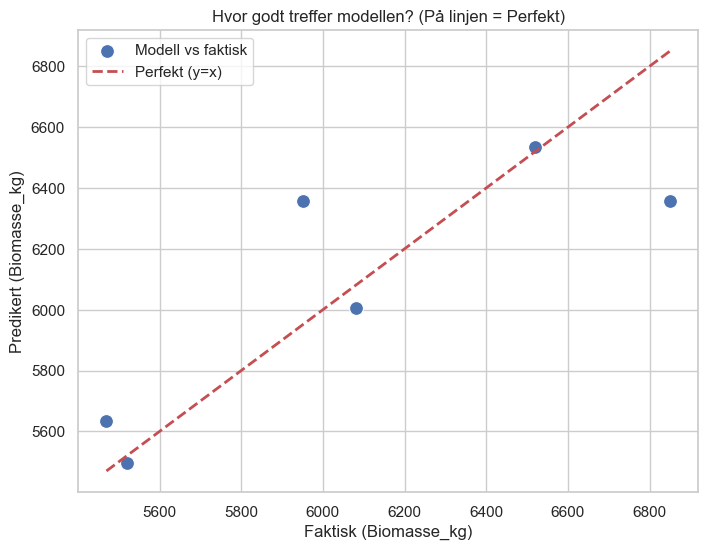

In [151]:
eval = predict_and_show(modell, X_test, y_test)

In [152]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

def evaluate_model(y_true, y_pred):
    # Beregn noen vanlige evalueringsmetrikker for modellens prediksjoner
    mae = mean_absolute_error(y_true, y_pred)
    #rmse = root_mean_squared_error(y_true, y_pred)
    rmse = ((y_true.values - y_pred) ** 2).mean() ** 0.5
    r2 = r2_score(y_true, y_pred)
    mape = (abs((y_true.values - y_pred) / y_true.values).mean()) * 100

    print(f"MAE:  {mae:.2f} kg")
    print(f"RMSE: {rmse:.2f} kg")
    print(f"MAPE: {mape:.2f} %")
    print(f"R^2:  {r2:.3f}")

In [153]:
eval.head()

,Faktisk (Biomasse_kg),Predikert (Biomasse_kg),Feil (Biomasse_kg)
27,6850,6357.8,492.2
15,5950,6357.8,-407.8
23,6520,6534.2,-14.2
17,6080,6005.0,75.0
8,5470,5633.6,-163.6


In [154]:

y_true = eval[f'Faktisk ({target})']
y_pred = eval[f'Predikert ({target})']
evaluate_model(y_true, y_pred)

MAE:  196.03 kg
RMSE: 271.32 kg
MAPE: 3.15 %
R^2:  0.703


## 5. Forbedring av modell
Kan vi lage en bedre modell? Har temperatur noe å si for vekst?

In [155]:
# Tar vare på original dataframe
old_df = df.copy()

In [156]:
# Lag ny kolonne med daglig endring i biomasse (kg)
df['endring'] = df['Biomasse_kg'].diff() #.fillna(0)

# Fjerner første rad siden endring er 0 der
df = df.dropna()

Korrelasjon (Foring_kg vs endring): 0.945


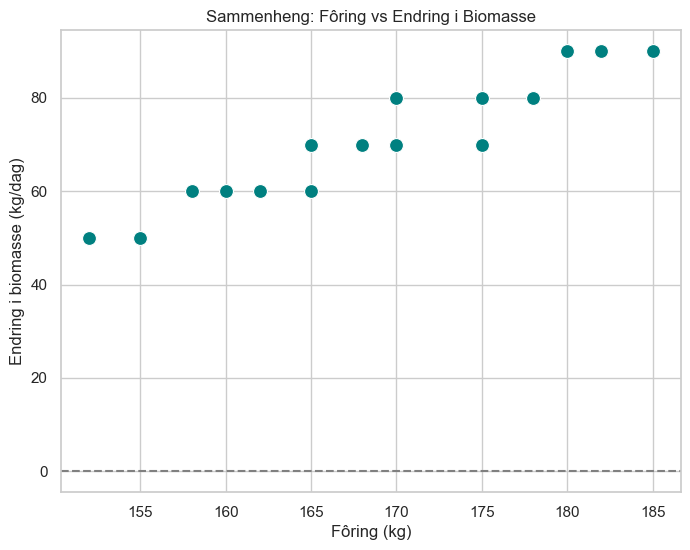

,Dato,Foring_kg,Biomasse_kg,endring
1,2024-01-02,155,5050,50.0
2,2024-01-03,152,5100,50.0
3,2024-01-04,158,5160,60.0
4,2024-01-05,160,5220,60.0
5,2024-01-06,165,5290,70.0


In [157]:
# Korrelasjon mellom fôring og endring
kor = df['Foring_kg'].corr(df['endring'])
print(f"Korrelasjon (Foring_kg vs endring): {kor:.3f}")

# Plott sammenhengen
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Foring_kg', y='endring', s=100, color='teal')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Fôring (kg)")
plt.ylabel("Endring i biomasse (kg/dag)")
plt.title("Sammenheng: Fôring vs Endring i Biomasse")
plt.show()

# Vis noen rader for å bekrefte den nye kolonnen
df[['Dato', 'Foring_kg', 'Biomasse_kg', 'endring']].head()

Modellen er ferdig trent!


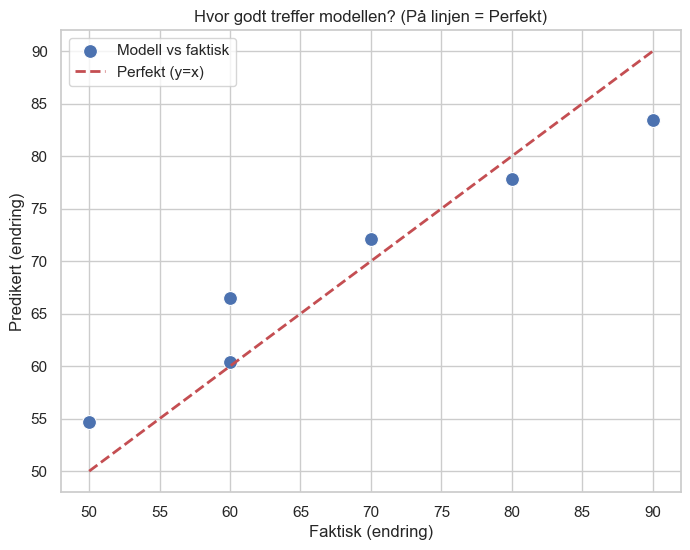

MAE:  3.75 kg
RMSE: 4.42 kg
MAPE: 5.66 %
R^2:  0.892


In [158]:
target = 'endring'
X_test, y_test, modell = train_model(df, features, target=target)
eval = predict_and_show(modell, X_test, y_test)
y_true = eval[f'Faktisk ({target})']
y_pred = eval[f'Predikert ({target})']
evaluate_model(y_true, y_pred)